Fit interpretable models to the training set and test on validation sets.

In [45]:
# % matplotlib inline
# % load_ext autoreload
# % autoreload 2

import os
import pickle as pkl
from os.path import join as oj

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

import numpy as np
import pandas as pd

import imodels
from rulevetting.api import validation
from rulevetting.projects.iai_pecarn.dataset import Dataset


MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output

In [8]:
# FIXME: replace with the correct dataset
from rulevetting.projects.iai_pecarn.dataset import Dataset

In [10]:
Dataset().get_data(load_csvs=True)

(      AbdDistention_no  AbdDistention_or_AbdomenPain_no  \
 6071                 1                                1   
 3780                 1                                1   
 7533                 1                                1   
 2619                 1                                1   
 8520                 1                                1   
 ...                ...                              ...   
 2696                 1                                1   
 6451                 1                                0   
 1848                 1                                1   
 4512                 1                                1   
 8969                 1                                1   
 
       AbdDistention_or_AbdomenPain_yes  AbdDistention_unknown  \
 6071                                 0                      0   
 3780                                 0                      0   
 7533                                 0                      0   
 2619         

In [18]:
df_train, df_tune, _ = Dataset().get_data(load_csvs=True)
X_train = df_train.drop(columns="outcome")
y_train = df_train["outcome"].values
X_tune = df_tune.drop(columns="outcome")
y_tune = df_tune["outcome"].values
processed_feats = df_train.keys().values.tolist()


def rename(x):
    RENAME_DICT = {}
    x = (
        RENAME_DICT
            .get(x, x.replace('_yes', '')
                 .replace('_', ' '))
            .replace('ThoracicTrauma', 'Thoracic Trauma')
            .replace('VomitWretch', 'Vomit/wretch')
            .replace('AbdDistention or AbdomenPain', 'Abdominal distention / Abdomen pain')
            .replace('DecrBreathSounds', 'Decreased breath sounds')
            .replace('AbdTenderDegree None', 'No Abdominal Tenderness')
    )
    return x


feature_names = [rename(x) for x in list(X_train)]


def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

In [19]:
df_train.outcome

6071    0
3780    0
7533    0
2619    0
8520    0
       ..
2696    0
6451    0
1848    0
4512    0
8969    0
Name: outcome, Length: 7226, dtype: int64

# fit simple models

**decision tree**

100%|██████████| 6/6 [00:00<00:00, 841.16it/s]


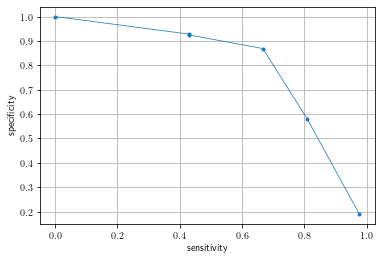

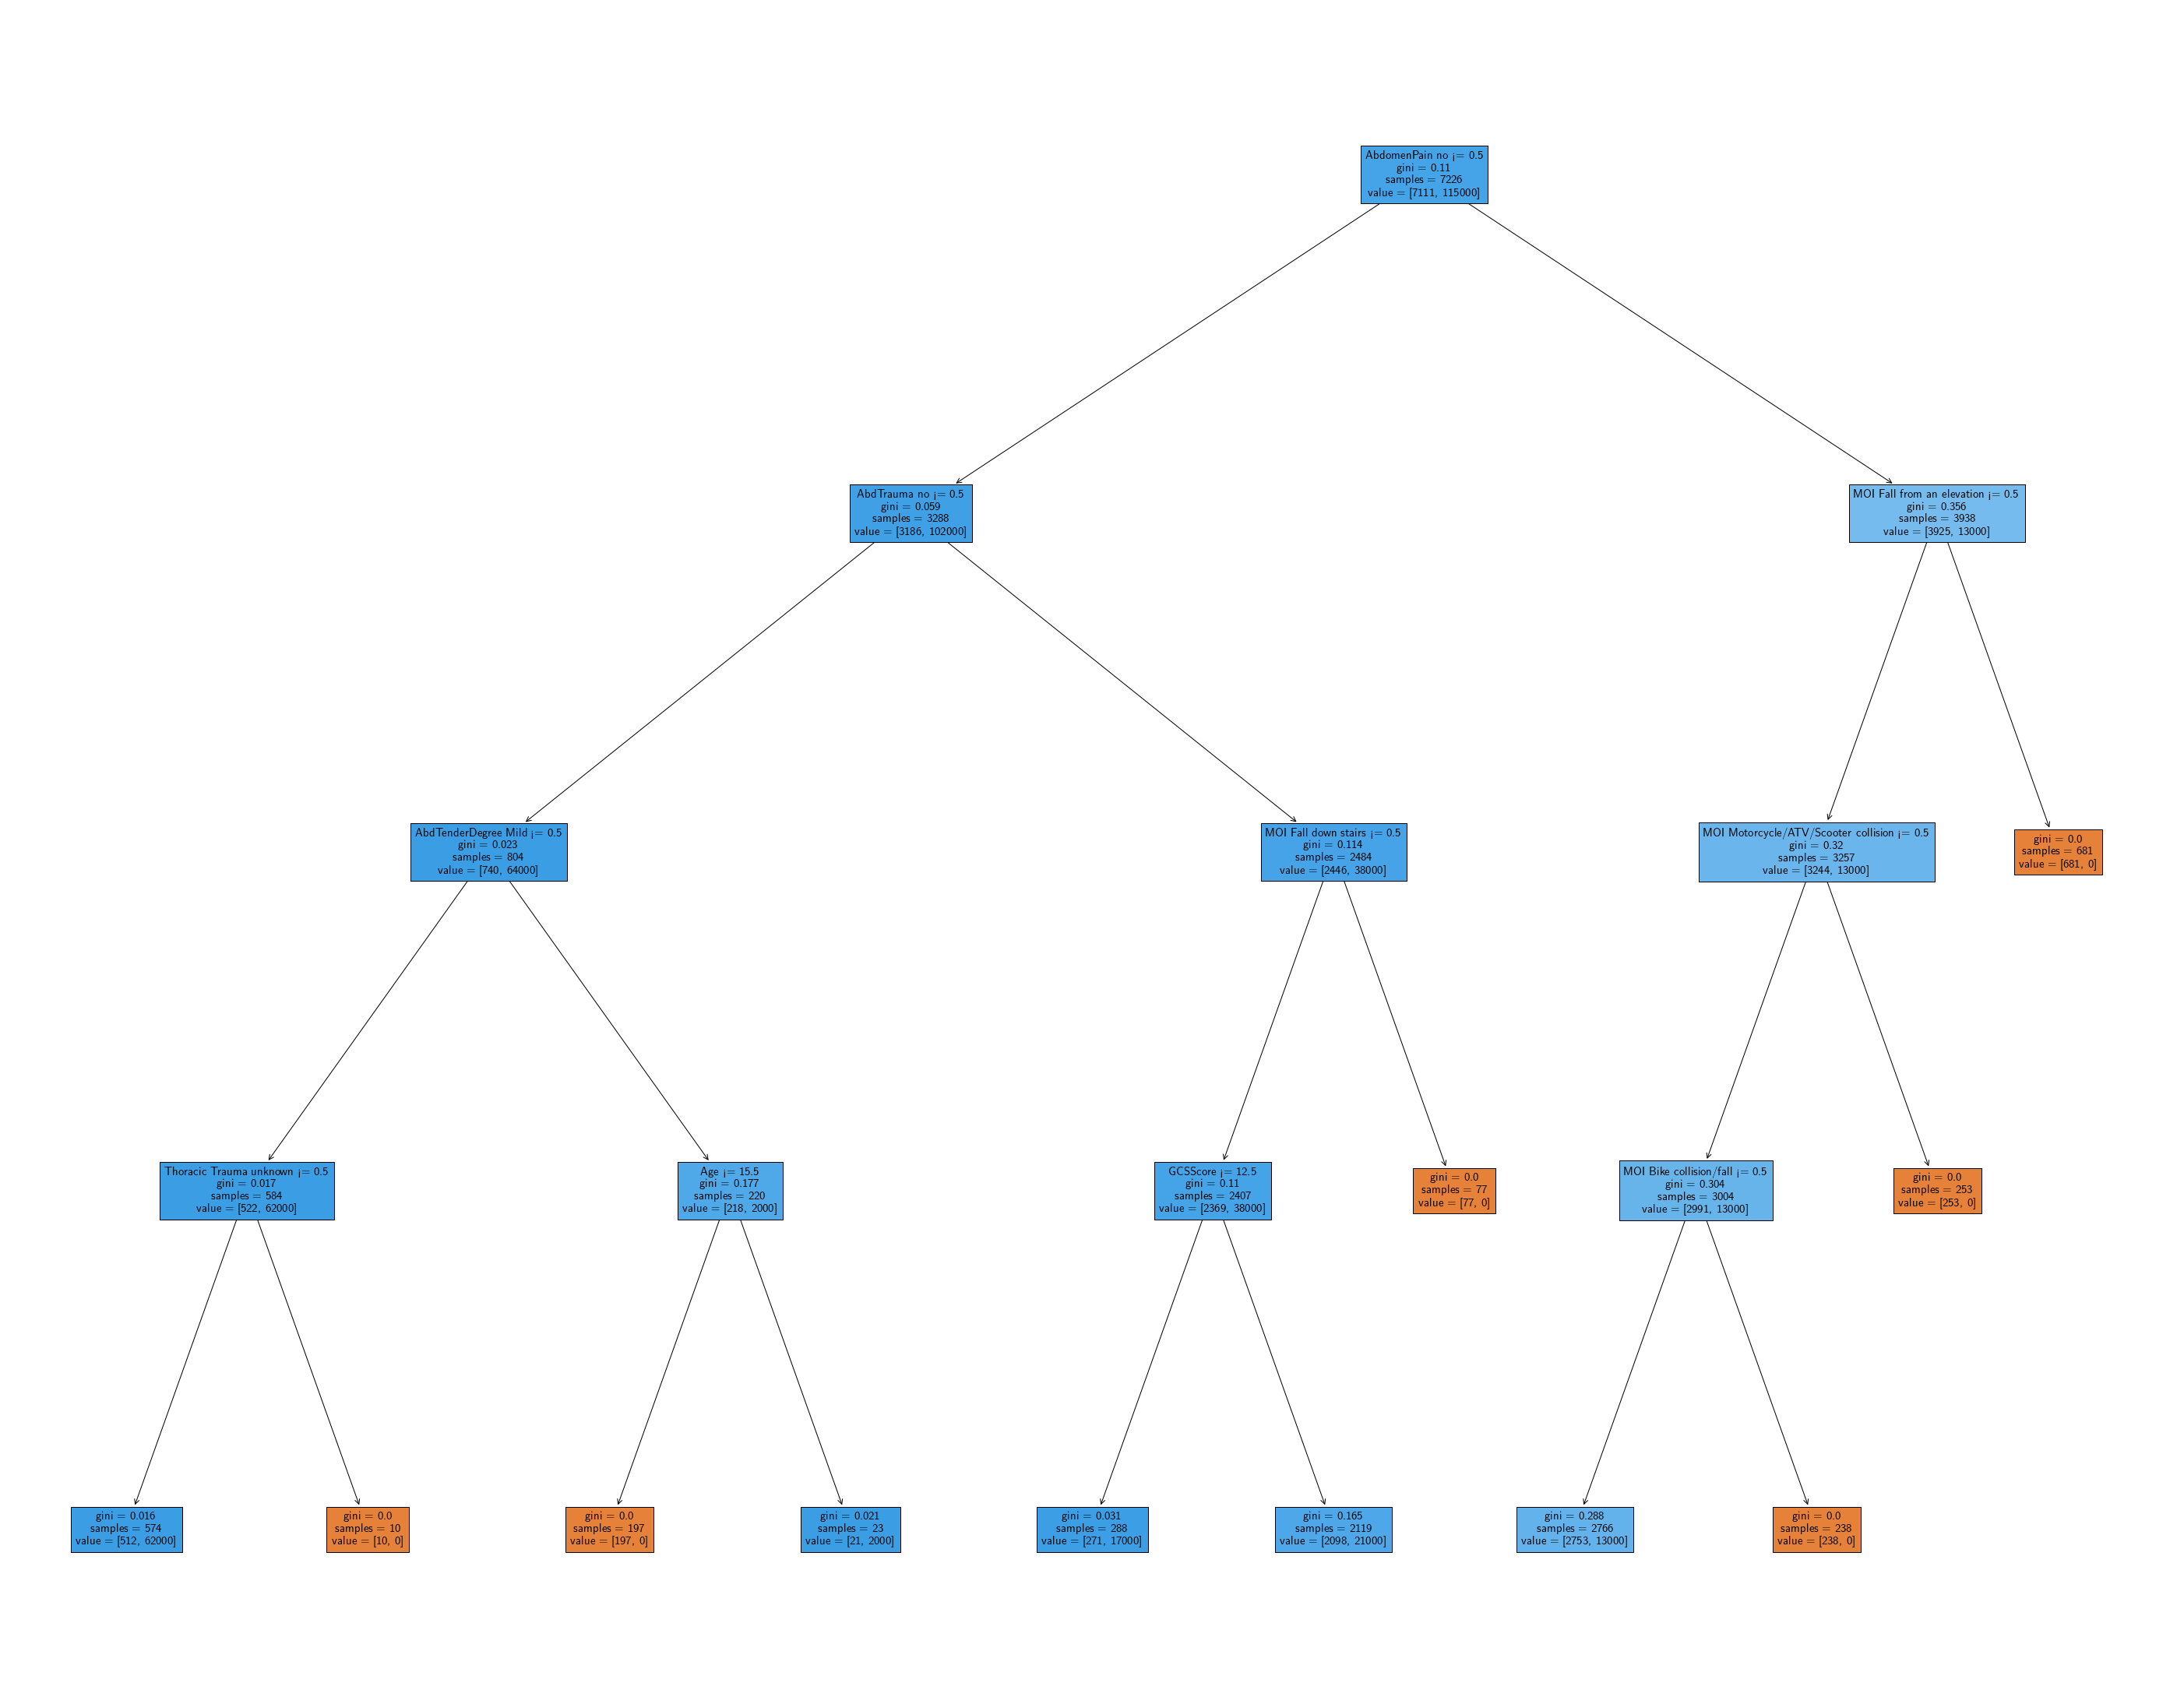

In [34]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1: 1e3})
dt.fit(X_train, y_train)
stats, threshes = predict_and_save(dt, model_name='decision_tree')
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

**bayesian rule list (this one is slow)**

In [ ]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = imodels.BayesianRuleListClassifier(listlengthprior=2, max_iter=10000, class1label="IwI", verbose=False)
brl.fit(X_train, y_train, feature_names=feature_names)
stats, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

training bayesian_rule_list...


In [ ]:
print(brl)

**rulefit**

100%|██████████| 54/54 [00:00<00:00, 620.59it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

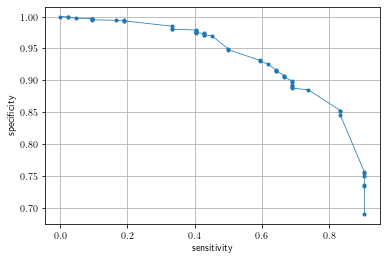

In [39]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitRegressor(max_rules=4)
rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [40]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
10,AbdTrauma no,-0.01
11,AbdTrauma or SeatBeltSign no,-0.01
12,AbdTrauma or SeatBeltSign,0.00
29,GCSScore,-0.01
59,AbdDistention <= 0.5 and AbdTenderDegree Severe <= 0.5,-0.05
60,AbdDistention <= 0.5 and AbdTenderDegree Severe <= 0.5,-0.00
58,Abdominal distention / Abdomen pain no > 0.5 and GCSScore > 3.5 and AbdTenderDegree Severe <= 0.5,-0.00


**greedy (CART) rule list**

/home/andrej/myStuff/berkeley/STAT215A/assignments/final/rule-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/andrej/myStuff/berkeley/STAT215A/assignments/final/rule-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 9/9 [00:00<00:00, 1066.62it/s]


mean 0.016 (7226 pts)
if AbdDistention >= 1.0 then 0.175 (166 pts)
mean 0.012 (7060 pts)
if feat 8 >= 1.0 then 0.121 (223 pts)
mean 0.009 (6837 pts)
if feat 50 >= 1.0 then 0.044 (615 pts)
mean 0.005 (6222 pts)
if feat 46 >= 1.0 then 0.029 (307 pts)
mean 0.004 (5915 pts)
if feat 6 >= 1.0 then 0.012 (805 pts)
mean 0.003 (5110 pts)
if feat 43 >= 3.0 then 0.02 (101 pts)
mean 0.002 (5009 pts)
if feat 18 >= 17.0 then 0.009 (459 pts)
mean 0.002 (4550 pts)
if feat 33 >= 1.0 then 0.024 (42 pts)
mean 0.001 (4508 pts)
if feat 35 >= 1.0 then 0.007 (302 pts)



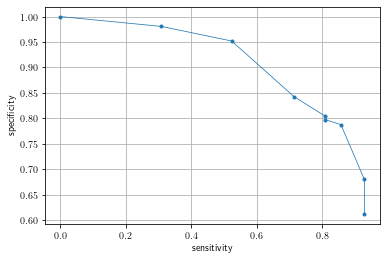

In [41]:
class_weight = {0: 1, 1: 100}
d = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(d, model_name='grl')
# d.print_list()
print(d)

**rf**

In [42]:
# # specify a decision tree with a maximum depth
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# sens, spec, threshes = predict_and_save(rf, model_name='rf')
# # sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1])
# imps = rf.feature_importances_.round(3)
# args = np.argsort(imps)
# imps = imps[args]
# feats = np.array(processed_feats)[args]
# for imp, feat in zip(imps, feats):
#     print(feat, imp)

# look at all the results

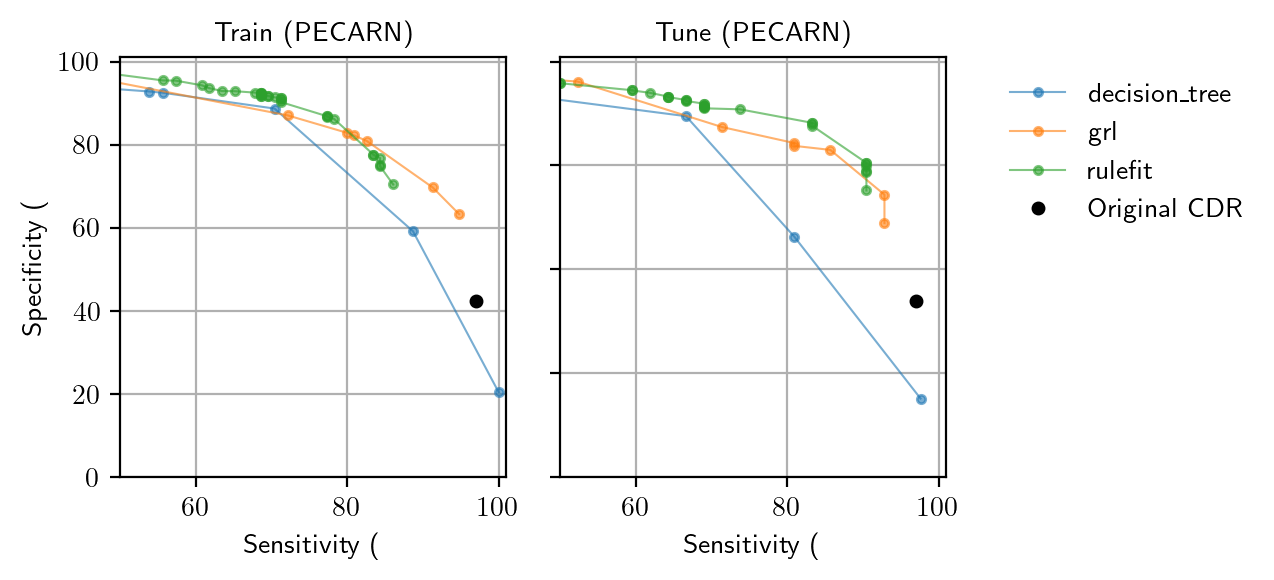

In [43]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'o', color='black', label='Original CDR', ms=4)
    else:
        plt.plot(97.0, 42.5, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (PECARN)', 'Tune (PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
plt.savefig('figs/metrics_3_splits')
plt.show()

100%|██████████| 54/54 [00:00<00:00, 743.21it/s]


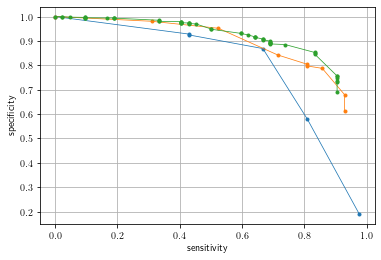

In [46]:
def print_metrics(suffix):
    vals = {s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'brier_score', 'f1']}
    fnames = []
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                threshes = np.array(r['threshes' + suffix])
                m = r['model']

                # add more stats
                for x, y, suff in zip([X_train, X_tune],
                                      [y_train, y_tune],
                                      ['_train', '_tune']):
                    if suff == suffix:
                        stats, threshes = validation.all_stats_curve(y, m.predict_proba(x)[:, 1],
                                                                     plot=suffix == '_tune')
                        preds_proba = m.predict_proba(x)[:, 1]
                        brier_score = metrics.brier_score_loss(y, preds_proba)

                # pick best vals
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                best_idx = np.argmax(5 * sens + spec)
                for k in vals.keys():
                    if not k == 'brier_score':
                        #                         print('k', k)
                        vals[k].append(stats[k][best_idx])
                vals['brier_score'].append(brier_score)
                fnames.append(fname[:-4])
    stats = pd.DataFrame.from_dict(vals)
    stats.index = fnames
    return (stats).round(2).transpose()


suffixes = ['_train', '_tune']  # _train, _test1, _test2
stats_list = {}
for i, suffix in enumerate(suffixes):
    stats_list[suffix] = print_metrics(suffix)

In [47]:
stats_list['_train']

,decision_tree,grl,rulefit
sens,1.00,0.95,0.86
spec,0.20,0.63,0.70
ppv,0.02,0.04,0.04
npv,1.00,1.00,1.00
lr+,1.26,2.58,2.91
lr-,0.00,0.08,0.20
brier_score,0.61,0.01,0.08
f1,0.04,0.08,0.09


In [48]:
stats_list['_tune']

,decision_tree,grl,rulefit
sens,0.98,0.93,0.90
spec,0.19,0.68,0.76
ppv,0.02,0.05,0.06
npv,1.00,1.00,1.00
lr+,1.20,2.90,3.71
lr-,0.13,0.11,0.13
brier_score,0.62,0.02,0.08
f1,0.04,0.09,0.12
